<img style ="float:right" src = "https://d1vwxdpzbgdqj.cloudfront.net/s3-public-images/learning-partners/greatlearning-brand.svg" width=15%>


<h1 id="Case-Study-4.1:-Create-a-Movie-Recommender">Case Study 4.1: Create a Movie Recommender<a class="anchor-link" href="https://courses.edx.org/asset-v1:MITxPRO+DSx+2T2019+type@asset+block@case_study_4.1_notebook_python_beginner.html#Case-Study-4.1:-Create-a-Movie-Recommender">¶</a></h1>


## Import

### One of the first steps in any data science task is importing the necessary tools you will use.



In [1]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 6.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633974 sha256=98a8aee91d092ac12b50405b29bc15e8920e4c223b468bc005db6b6cf571d6a9
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


##### Note: If !pip install scikit-surprise doesn't work, please install using the anconda prompt by typing the following command
      conda install -c conda-forge scikit-surprise 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise import  SVD, NormalPredictor, KNNBasic
from surprise.model_selection import cross_validate
from surprise import accuracy
from IPython.display import display
from collections import defaultdict
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

## Reading the Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#data = pd.read_table('/content/drive/MyDrive/u.data')
col_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_table('/content/drive/MyDrive/u.data', names=col_names)
data = data.drop('timestamp', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  100000 non-null  int64
 1   item_id  100000 non-null  int64
 2   rating   100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [5]:
data.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


## 1. Describe the dataset. How many ratings are in the dataset? How would you describe the distribution of ratings? Is there anything else we should observe? Make sure the histogram is visible in the notebook. 

In [6]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
user_id,100000.0,462.48475,266.614420,1.0,254.0,447.0,682.0,943.0
item_id,100000.0,425.53013,330.798356,1.0,175.0,322.0,631.0,1682.0
rating,100000.0,3.52986,1.125674,1.0,3.0,4.0,4.0,5.0


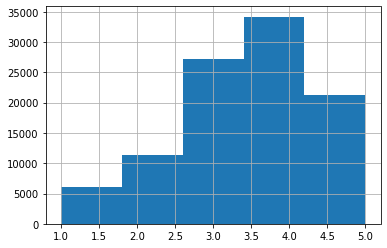

In [7]:
data.rating.hist(bins=5)
plt.show()

In [8]:
data.shape

(100000, 3)

**Ans:**

*Dataset has about 100000 rows and 3 columns. There are no Nulls in the dataset. The ratings are ranging from 1 to 5.*

*Data seems to be highly skewed towards Rating '4'. Rating '4' is the highest in count and only some i.e. less than 50% of Rating '4'.*

*We could've kept a subset of the data so as to keep only those instances where count of ratings is greater than 100. Hence, the updated data would've the shape 74522, 3.*


In [9]:
# Get the column containing the users
users = data.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [10]:
# We want our users to have at least 100 ratings to be considred
RATINGS_CUTOFF = 100
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
data_less = data.loc[~data.user_id.isin(remove_users)]

In [11]:
data_less.shape

(74522, 3)

## Cross Validation


We will be using cross validation a lot in this code in the training and evaluation of our models. This strategy builds upon the idea of a train-test split, which you should already be familiar with.

Instead of doing 1 data split, though, we will do several of them. Each split of the data is called a fold. We let k denote the number of folds we use. k=5 is a common number to use.

This image provides a visual explanation of how cross validation works.

<img src ="https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg"></img>

### We will use "cross_validate" from surprise package to run the models as listed and check their respective RMSEs

In [12]:
#coverting data in to surprise dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

## Model 1: Random

We want to first get a baseline value for our model. What better way to do that than with a random algorithm! Essentially, this first algorithm is not personalized to the desires of any users - we just assign them movie ratings based on the initial distribution of the data.

See the Model 1: Random section of your notebook and follow the instructions to create a new model, train it on the data and evaluate the RMSE.

In [13]:
#Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
model_random = NormalPredictor()

In [14]:
model_using_normal_predictor = cross_validate(model_random, data,measures=['RMSE'],cv=5, verbose=False)

In [15]:
print('Average RMSE for Test Set using {} is '.format(model_random.__class__.__name__),model_using_normal_predictor['test_rmse'].mean())

Average RMSE for Test Set using NormalPredictor is  1.51980501002599


## Model 2: User-Based Collaborative Filtering

Surely, we can do much better than guessing the movie ratings randomly! Our next model will use the user-user defined notion of similarity to implement collaborative filtering.

See the Model 2: User-Based Collaborative Filtering section of your notebook and follow the instructions to create a new model, train it on the data and evaluate the RMSE.


 We will use KNNBasic and add parameter 'cosine' 

In [16]:
model_user_based = KNNBasic(sim_options ={'name':'cosine','user_base':True},verbose=False)
model_using_KNNbasic_cos_user = cross_validate(model_user_based,data,measures=['RMSE'],cv=5, verbose=False)

In [17]:
print('Average RMSE for Test Set using {} is '.format(model_user_based.__class__.__name__),model_using_KNNbasic_cos_user['test_rmse'].mean())

Average RMSE for Test Set using KNNBasic is  1.0163166019815109


## Model 3: Item-Based Collaborative Filtering

Our next model will use the item-item defined notion of similarity to once again implement collaborative filtering.

See the Model 3: Item-Based Collaborative Filtering section of your notebook and follow the instructions to create a new model, train it on the data and evaluate the RMSE.

In [18]:
model_item_based = KNNBasic(sim_options ={'name':'cosine','user_base':False},verbose=False)
model_using_KNNbasic_cos_item = cross_validate(model_item_based,data,measures=['RMSE'],cv=5, verbose=False)

In [19]:
print('Average RMSE for Test Set using {} is '.format(model_item_based.__class__.__name__),model_using_KNNbasic_cos_item['test_rmse'].mean())

Average RMSE for Test Set using KNNBasic is  1.0173972539433322


## 2.	Compare the results from the user-user and item-item models. How do they compare to each other? How do they compare to our original "random" model? Can you provide any intuition as to why the results came out the way they did?

**Ans:**

*User-based and Item-based Collaborative Models have nearly same RMSE values (around 1.017) while the "random" model's RMSE is highest (1.52). Clearly, Collaborative Filtering Models have performed better than random model.* 

*The Collaborative Models use the user-item-ratings data to find similarities and make predictions rather than just predicting a random rating based on the distribution of the data. This could a reason why the Collaborative Models performed well.*

## Model 4: Matrix Factorization

Our final model for this case study will use the matrix factorization approach with the SVD algorithm to try to predict user’s movie ratings. Here, we try to determine some underlying mathematical structure in the user rating matrix, which can help us predict missing ratings in the future.

See the Model 4: Matrix Factorization section of your notebook and follow the instructions to create a new model, train it on the data and evaluate the RMSE.

In [20]:
#matrix factorisation using svd
model_svd = SVD()
model_using_svd = cross_validate(model_svd,data,measures=['RMSE'],cv=5, verbose=False)

In [21]:
print('Average RMSE for Test Set using {} is '.format(model_svd.__class__.__name__),model_using_svd['test_rmse'].mean())

Average RMSE for Test Set using SVD is  0.9374585864512308


## 3.	The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference. Also, compare the RMSE again. Does it improve? Can you offer any reasoning as to why that might be?

**Ans:**

*Collaborative Filtering searches for neighbors based on similarity of product (example) preferences and recommend product that those neighbors bought/reviewed while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.*

*RMSE for Matrix Factorization is better than the Collaborative Filtering Models.*

*Matrix Factorization has lower RMSE due to the reason that it assumes  that  both product and users are present in some low dimensional space describing their properties and recommend a product based on its proximity to the user in the latent space. Implying it accounts for latent factors as well*

## Precision and Recall @ k

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

See the Precision and Recall @ k section of your notebook and follow the instructions to compute various precision/recall values at various values of k.

## 4.	Compute the precision and recall, for each of the 4 models, at k = 5 and 10. This is 2 x 2 x 4 = 16 numerical values. Do you note anything interesting about these values? Anything different from the RMSE values you computed above?

In [22]:
#function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [23]:
#A basic cross-validation iterator.
kf = KFold(n_splits=5)

In [24]:
# Make list of k values
K = [5, 10]

# Make list of models
models = [model_random, model_user_based, model_item_based, model_svd]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=NormalPredictor
-----> Precision:  0.562
-----> Recall:  0.317
> k=5, model=KNNBasic
-----> Precision:  0.735
-----> Recall:  0.44
> k=5, model=KNNBasic
-----> Precision:  0.736
-----> Recall:  0.433
> k=5, model=SVD
-----> Precision:  0.719
-----> Recall:  0.409
> k=10, model=NormalPredictor
-----> Precision:  0.574
-----> Recall:  0.418
> k=10, model=KNNBasic
-----> Precision:  0.704
-----> Recall:  0.574
> k=10, model=KNNBasic
-----> Precision:  0.703
-----> Recall:  0.574
> k=10, model=SVD
-----> Precision:  0.702
-----> Recall:  0.544


**Ans:**

> Precision quantifies the number of positive class predictions that actually belong to the positive class. 

> Recall quantifies the number of positive class predictions made out of all positive examples in the dataset. 

*These values are lowest for Random. Collaborative Filtering performed well in both the k values with Precision value ~74% with k=5 and Precision value ~89% with k=10.*

*SVD has better RMSE but Collaborative Filtering using Item-Item or User-User have better Precision & Recall.*

*RMSE values are used for Continuous d-type while Precision-Recall are calculated for categorical d-type using Confusion matrix. Thus cannot be compared directly.*

## Top-n Predictions

Finally, we want to actually see what ratings the model predicts for our users. We can vary the amount of top movies we see per user by varying the value of n.

See the Top-n Predictions section of your notebook and follow the instructions to compute rating predictions for some users.

 <a href=https://surprise.readthedocs.io/en/stable/FAQ.html>documentation surprise</a>

In [25]:

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [26]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [27]:
models = [model_random, model_user_based, model_item_based, model_svd]
for model in models:
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Print the first one
    user = list(top_n.keys())[0]
    print(f'model: {model.__class__.__name__}, {user}: {np.round(top_n[user],2)}')

model: NormalPredictor, 196: [[  86    5]
 [1014    5]
 [  98    5]
 [   4    5]
 [  15    5]]
model: KNNBasic, 196: [[1189    5]
 [1500    5]
 [ 814    5]
 [1536    5]
 [1293    5]]
model: KNNBasic, 196: [[1189    5]
 [1500    5]
 [ 814    5]
 [1536    5]
 [1293    5]]
model: SVD, 196: [[169.     4.83]
 [187.     4.67]
 [408.     4.59]
 [963.     4.58]
 [480.     4.54]]


In [29]:
# Getting Top 10 predictions of the user
models = [model_random, model_user_based, model_item_based, model_svd]
for model in models:
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=10)
    # Print the first one
    user = list(top_n.keys())[0]
    print(f'model: {model.__class__.__name__}, {user}: {np.round(top_n[user],2)}')

model: NormalPredictor, 196: [[451   5]
 [144   5]
 [ 95   5]
 [427   5]
 [750   5]
 [658   5]
 [177   5]
 [298   5]
 [258   5]
 [673   5]]
model: KNNBasic, 196: [[1189    5]
 [1500    5]
 [ 814    5]
 [1536    5]
 [1293    5]
 [1599    5]
 [1653    5]
 [1467    5]
 [1122    5]
 [1201    5]]
model: KNNBasic, 196: [[1189    5]
 [1500    5]
 [ 814    5]
 [1536    5]
 [1293    5]
 [1599    5]
 [1653    5]
 [1467    5]
 [1122    5]
 [1201    5]]
model: SVD, 196: [[191.     4.45]
 [963.     4.45]
 [192.     4.44]
 [408.     4.44]
 [ 50.     4.43]
 [187.     4.41]
 [357.     4.39]
 [483.     4.38]
 [313.     4.37]
 [318.     4.35]]


## 5.	Do the top n predictions that you received make sense? What is the rating value (1-5) of these predictions? How could you use these predictions in the real-world if you were trying to build a generic content recommender system for a company?

**Ans:**


*As expected, we have got the predictions (n=5) for each model. We printed the predictions for One user for each model. Collaborative models  (User-based & Item-based) have given exactly same recommendations.*

*The rating values for Random, User-based, Item-based is fixed at 5. However, rating value for Matrix Factorization using SVD is non-integer and less than 5.*


*Recommender systems are used by OTT platforms and streaming sites to recommend movies to their users. The movies can be recommended based on the top overall favorites/most-watched on a site, based on the demographics of the user, or based on an analysis of the past buying viewing of the user as a prediction for future viewing behavior.*

<H3 style ="text-align:center"><strong> Happy Learning</strong></H3>